Eigenvalue MC code

In [1]:
import numpy as np
import numpy.random as round
import matplotlib.pyplot as plt

from models import globalvariables as GV
from models import geometry_models as geo_m
from models import physic_model as phy_m
from models import material_model as mat_m
from models import statistic_model as stat_m

from controllers import geometry_controller as geo_c
from controllers import physics_controller as phy_c
from controllers import material_controller as mat_c
from controllers import statistic_controller as stat_c

Import data

In [2]:
Cnat_total = np.loadtxt('cross_sections_Janis\\C\\Cnat_total.csv', delimiter=';',skiprows=3)
Cnat_scattering = np.loadtxt('cross_sections_Janis\\C\\Cnat_scattering.csv', delimiter=';', skiprows=3)

Fe_total = np.loadtxt('cross_sections_Janis\\Fe\\Fe_total.csv', delimiter=';',skiprows=3)
Fe_scattering = np.loadtxt('cross_sections_Janis\\Fe\\Fe_scattering.csv', delimiter=';', skiprows=3)

Onat_total = np.loadtxt('cross_sections_Janis\\O\\Onat_total.csv', delimiter=';',skiprows=3)
Onat_scattering = np.loadtxt('cross_sections_Janis\\O\\Onat_scattering.csv', delimiter=';', skiprows=3)

U238_total = np.loadtxt('cross_sections_Janis\\U238\\U238_total.csv', delimiter=';',skiprows=3)
U238_scattering = np.loadtxt('cross_sections_Janis\\U238\\U238_scattering.csv', delimiter=';', skiprows=3)
U238_fission = np.loadtxt('cross_sections_Janis\\U238\\U238_fission.csv', delimiter=';', skiprows=3)

U235_total = np.loadtxt('cross_sections_Janis\\U235\\U235_total.csv', delimiter=';',skiprows=3)
U235_scattering = np.loadtxt('cross_sections_Janis\\U235\\U235_scattering.csv', delimiter=';', skiprows=3)
U235_fission = np.loadtxt('cross_sections_Janis\\U235\\U235_fission.csv', delimiter=';', skiprows=3)

Create isotopes

In [3]:
carbon = mat_m.isotope(6,12,1.1E23,Cnat_total[:,0],Cnat_total[:,1],Cnat_scattering[:,1])
iron = mat_m.isotope(26,56,8.6E22,Fe_total[:,0],Fe_total[:,1],Fe_scattering[:,1])
uranium238 = mat_m.isotope(92,238,2*1.76E22,U238_total[:,0],U238_total[:,1],U238_scattering[:,1],U238_fission[:,1],2.5)
uranium235 = mat_m.isotope(92,235,2*4.4E21,U235_total[:,0],U235_total[:,1],U235_scattering[:,1],U235_fission[:,1],2.5)
source = phy_m.source(GV.LL,100,GV.SOURCE_POSITION,1.,'watt')

Create materials

In [4]:
core_list = [uranium238, uranium235]
core = mat_m.material(core_list)
reflector_list = [iron,carbon]
reflector = mat_m.material(reflector_list)

Tally creations

In [5]:
distribution = [(core,0,200),(reflector,200,300)]
domain = geo_m.domain(distribution,GV.LL,1000,GV.EE,2000,True)
tally = stat_m.tally(GV.LL,50)
KK = [GV.Kin,GV.Kin]

Monte Carlo code

In [6]:
for ii in range(int(GV.Nskip)):
    ww = GV.Nstories/source.tot_generated
    phy_c.generate_population(source,ww)
    Keff = KK[-1]
    Knew = 0
    source.reset_source()
    for nn in stat_m.particle_squeue:
        while nn.eof > 0:
            nn.position = phy_c.sample_free_flight(nn,domain)
            if geo_c.is_outofbound(nn,'space'):
                nn.eof = 0
            else:
                Knew += phy_c.implicit_fission(nn,domain,Keff,source)
                # aggiorno i dati della particella dopo l'interazione
                nn.energy = phy_c.sample_energy_stepf(nn,domain)
                nn.direction = geo_m.direction.get_rnd_direction()
                nn.weight = phy_c.new_weight(nn,domain)
                # controllo l'energia
                if geo_c.is_outofbound(nn,'energy') is True:
                    nn.eof = 0
                else:
                    # russian roulette e splitting
                    stat_c.russian_roulette(nn)
                    stat_c.splitting(nn)
    source.s_entropy()
    stat_c.restart_cycle()
    KK.append(Knew)


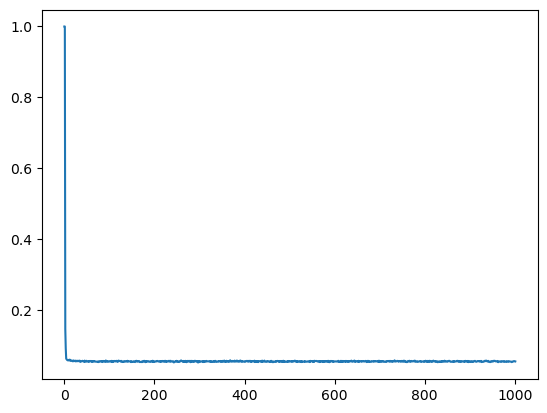

In [7]:
plt.plot(KK)